# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

# Описание данных

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./Churn.csv')

In [3]:
#посмотрим таблицу
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
#количество дубликатов
data.duplicated().sum()

0

In [5]:
#информация о таблице (есть пропуски в столбце Tenure(сколько лет человек является клиентом банка))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
#заменим пропуски на 0
data['Tenure'] = data['Tenure'].fillna(0).astype(int)

In [7]:
#проверка
data['Tenure'].isnull().sum()

0

In [8]:
#посмотрели пол
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [9]:
#посмотрели страны
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
#приведем к нижнему регистру названия столбцов
data.columns = data.columns.str.lower()
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [11]:
#приведем к нижнему регистру значения столбцов:
for column in data[['surname','geography','gender']]:
    data[column] = data[column].str.lower()

В нашей таблице есть столбцы с данными, которые никак в дальнейшем не повлияют на результат - это 'rownumber', 'customerid', 'surname'. Их можно удалить, что мы и сделаем.

In [12]:
data = data.drop(['rownumber','customerid','surname'], axis=1)
data.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

Так же создадим датафрейм по методу прямого кодирования с защитой от дамми-ловушки.

In [13]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


Вывод:
- пропуски в столбце Tenure заменили на 0, так как их немного;
- поменяли тип данных с float на int столбца Tenure;
- привели к общему регистру названия столбцов и значения столбцов: 'surname','geography','gender';
- дубликатов нет;
- избавились от не нужных столбцов 'rownumber','customerid','surname';
- провели прямое кодирование с защитой от дамми-ловушки.

## Исследование задачи

У нас целевой признак Exited (факт ухода клиента) — это категориальный признак. Следовательно, задача будет достигаться методами классификации.

Рассмотрим модели:
- дерево решений;
- случайный лес;
- логистическая регрессия.

Для начало разобьём данные на 60/20/20

In [14]:
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                              test_size=0.5, 
                                                                              random_state=12345)
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


Посмотрим дисбаланс классов:

In [15]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Объектов отрицательного класса почти в 4 раза больше объектов положительного класса. Изучим модели без исправления дисбаланса.

### Дерево решений

In [16]:
%%time

best_depth = 0
best_score = 0
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    a = f1_score(target_valid, predicted_valid)
    if a > best_score:
        best_score = a
        best_depth = depth
        
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth)

Самый высокий f1_score: 0.5786516853932585  при глубине дерева: 9
CPU times: user 241 ms, sys: 3.81 ms, total: 245 ms
Wall time: 245 ms


### Cлучайный лес

In [17]:
%%time

best_depth = 0
best_est = 0
best_score = 0
for depth in range(1,20):
    for est in range(10,60,10):
        model = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est)
        model.fit(features_train,target_train)
        predicted_valid = model.predict(features_valid)
        a = f1_score(target_valid, predicted_valid)
        if a > best_score:
            best_depth = depth
            best_est = est
            best_score = a
 
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth, ' \
и  количестве деревьев:', best_est)

Самый высокий f1_score: 0.6011730205278591  при глубине дерева: 16  и  количестве деревьев: 40
CPU times: user 12.4 s, sys: 130 ms, total: 12.5 s
Wall time: 12.5 s


### Логистическая регрессия

In [18]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('F1_score', f1_score(target_valid, predicted_valid))

F1_score 0.08750000000000001
CPU times: user 150 ms, sys: 5.09 ms, total: 156 ms
Wall time: 43.6 ms


Возможно precision или recall близок к 0, поэтому такая маленькая F1_score.

### Построим ROC-кривую для каждой модели.

AUC-ROC дерева решений 0.7899719632952051
AUC-ROC случайного леса 0.8382301792292476
AUC-ROC логистической регрессии 0.6736022477755128


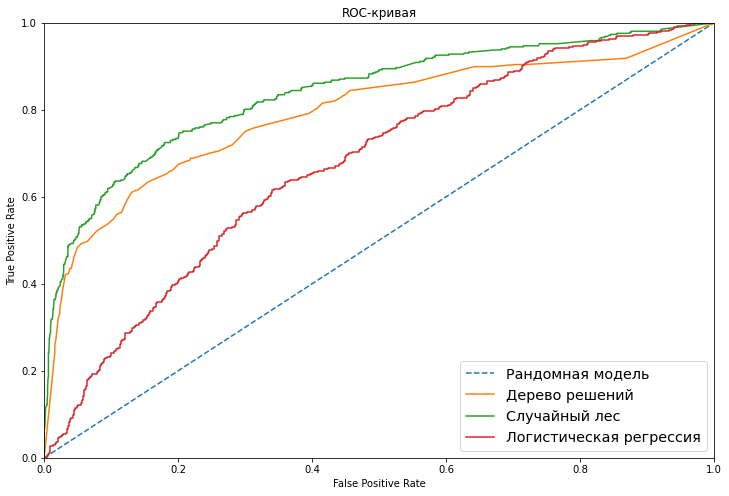

In [19]:
plt.figure(figsize=[12,8])

plt.plot([0, 1], [0, 1], linestyle='--', label='Рандомная модель')

model = DecisionTreeClassifier(random_state=12345, max_depth = 9)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC дерева решений',auc_roc)
plt.plot(fpr, tpr, label='Дерево решений')


model = RandomForestClassifier(random_state=12345, max_depth = 16, n_estimators=40)
model.fit(features_train,target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC случайного леса',auc_roc)
plt.plot(fpr, tpr, label='Случайный лес')


model = LogisticRegression(random_state=12345)
model.fit(features_train,target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC логистической регрессии',auc_roc)
plt.plot(fpr, tpr, label='Логистическая регрессия')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='x-large')
plt.title('ROC-кривая')
plt.show()

На графике видно, что модель Случайный лес лучше остальных, так как AUC-ROC = 0.838 и f1_score = 0.601

Вывод:

- разбили данные на обучающую выборку(60%), валидационную(20%) и тестовую(20%);
- посмотрели дисбаланс: объектов отрицательного класса 7963, а объектов положительного класса 2037
- при исследовании моделей самой лучшей оказался Случайный лес (метрика f1 = 0.601, AUC-ROC = 0.838)

## Борьба с дисбалансом

Расмотрим 3 метода борьбы с дисбалансом:
- взвешивание классов;
- уменьшение выборки;
- увеличение выборки.

### Взвешивание классов

In [20]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=12345, max_depth = 16, n_estimators=40, class_weight='balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.7625
Precision 0.4525790349417637
Recall 0.6507177033492823
F1 0.5338567222767419

Случайный лес
Точность попадания по классам 0.856
Precision 0.75
Recall 0.4665071770334928
F1 0.5752212389380531

Логистическая регрессия
Точность попадания по классам 0.6525
Precision 0.33492252681764006
Recall 0.6722488038277512
F1 0.44709626093874305



При взвешивание выборки, мера F1 в моделях Решающее дерево и Случайный лес уменьшилась, а в Логистической регрессии, наоборот, увеличилась.

In [21]:
best_depth = 0
best_score = 0
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth, class_weight='balanced') 
    model.fit(features_train, target_train) #обучили модель
    predicted_valid = model.predict(features_valid)
    a = f1_score(target_valid, predicted_valid)
    if a > best_score:
        best_score = a
        best_depth = depth
        
print('Решающее дерево')
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth)
print()

best_depth = 0
best_est = 0
best_score = 0
for depth in range(1,20):
    for est in range(10,60,10):
        model = RandomForestClassifier(random_state=12345, 
                                       max_depth = depth,
                                       n_estimators=est, 
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        a = f1_score(target_valid, predicted_valid)
        if a > best_score:
            best_depth = depth
            best_est = est
            best_score = a
 
print('Случайный лес')
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth, ' и  количестве деревьев:', best_est)
print()

model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('F1_score', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Самый высокий f1_score: 0.5963791267305644  при глубине дерева: 5

Случайный лес
Самый высокий f1_score: 0.631236442516269  при глубине дерева: 8  и  количестве деревьев: 50

Логистическая регрессия
F1_score 0.44709626093874305



 ### Уменьшение выборки

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
target_downsampled.value_counts()

0    1201
1    1196
Name: exited, dtype: int64

In [23]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=12345, max_depth = 16, n_estimators=40)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.749
Precision 0.4367469879518072
Recall 0.69377990430622
F1 0.5360443622920518

Случайный лес
Точность попадания по классам 0.7705
Precision 0.4681181959564541
Recall 0.7200956937799043
F1 0.5673892554194157

Логистическая регрессия
Точность попадания по классам 0.65
Precision 0.33372641509433965
Recall 0.6770334928229665
F1 0.44707740916271727



Если сравнивать меру F1 со взвешенным методом, то в Решающем дереве и Случайном лесе одинаковая, а в Логистической регрессии немного меньше.

### Увеличение выборки

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts()

0    4804
1    4784
Name: exited, dtype: int64

In [25]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=12345, max_depth = 16, n_estimators=40)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Точность попадания по классам 0.761
Precision 0.45
Recall 0.645933014354067
F1 0.5304518664047152

Случайный лес
Точность попадания по классам 0.845
Precision 0.6459459459459459
Recall 0.5717703349282297
F1 0.6065989847715736

Логистическая регрессия
Точность попадания по классам 0.6535
Precision 0.33532934131736525
Recall 0.6698564593301436
F1 0.44692737430167606



In [26]:
best_depth = 0
best_score = 0
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth) 
    model.fit(features_upsampled, target_upsampled) #обучили модель
    predicted_valid = model.predict(features_valid)
    a = f1_score(target_valid, predicted_valid)
    if a > best_score:
        best_score = a
        best_depth = depth
        
print('Решающее дерево')
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth)
print()

best_depth = 0
best_est = 0
best_score = 0
for depth in range(1,20):
    for est in range(10,60,10):
        model = RandomForestClassifier(random_state=12345, 
                                       max_depth = depth,
                                       n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        a = f1_score(target_valid, predicted_valid)
        if a > best_score:
            best_depth = depth
            best_est = est
            best_score = a
 
print('Случайный лес')
print('Самый высокий f1_score:', best_score, ' при глубине дерева:', best_depth, ' и  количестве деревьев:', best_est)
print()

model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('F1_score', f1_score(target_valid, predicted_valid))
print()

Решающее дерево
Самый высокий f1_score: 0.5963791267305644  при глубине дерева: 5

Случайный лес
Самый высокий f1_score: 0.6289156626506025  при глубине дерева: 13  и  количестве деревьев: 30

Логистическая регрессия
F1_score 0.44692737430167606



Мера F1 в Решающем дерево уменьшилась, в Случайном лесе и в Логистической регрессии увеличилась. 
Лучшая модель Случайный лес с увеличением выборки класса 1.

### Построим ROC-кривую с увеличением выборки для каждой модели.

AUC-ROC дерева решений 0.7601818302796411
AUC-ROC случайного леса 0.8399034593724859
AUC-ROC логистической регрессии 0.7131439822403959


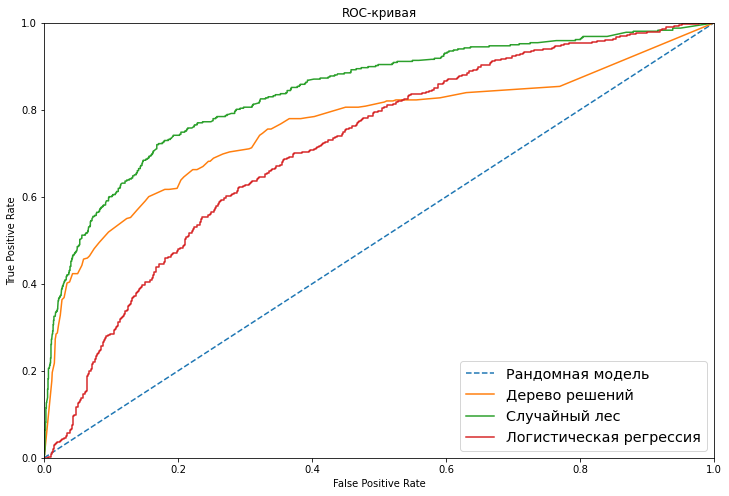

In [27]:
plt.figure(figsize=[12,8])

plt.plot([0, 1], [0, 1], linestyle='--', label='Рандомная модель')

model = DecisionTreeClassifier(random_state=12345, max_depth = 9)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC дерева решений',auc_roc)
plt.plot(fpr, tpr, label='Дерево решений')


model = RandomForestClassifier(random_state=12345, max_depth = 16, n_estimators=40)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC случайного леса',auc_roc)
plt.plot(fpr, tpr, label='Случайный лес')


model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC логистической регрессии',auc_roc)
plt.plot(fpr, tpr, label='Логистическая регрессия')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='x-large')
plt.title('ROC-кривая')
plt.show()

Вывод:
- лучший метод борьбы с дисбалансом оказалось увеличением выборки класса 1;
- модели случайный лес и логистическая регрессия увеличили свою меру F1, но AUC-ROC логистической регресии немного уменьшился;

## Тестирование модели

Улучшим меру F1 модели Случайный лес с помощью гиперпараметров на тестовой выборке.

In [28]:
model = RandomForestClassifier(random_state=12345, max_depth = 13, n_estimators=30, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
a = f1_score(target_test, predicted_test)
print('Самый высокий f1_score:', a, ' при глубине дерева:', 13, ' и  количестве деревьев:', 30)
print("Accuracy:", accuracy_score(predicted_test, target_test))

Самый высокий f1_score: 0.5970873786407767  при глубине дерева: 13  и  количестве деревьев: 30
Accuracy: 0.834


In [29]:
model.feature_importances_

array([0.11503147, 0.27612636, 0.06630351, 0.13607649, 0.14396626,
       0.01654308, 0.04943572, 0.11539879, 0.04370556, 0.01167334,
       0.02573943])

In [30]:
features_test.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_germany',
       'geography_spain', 'gender_male'],
      dtype='object')

In [31]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model.feature_importances_})
fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,name,fi
0,age,0.276126
1,numofproducts,0.143966
2,balance,0.136076
3,estimatedsalary,0.115399
4,creditscore,0.115031


## Вывод:

Мы проверили три модели: "Дерево решений", "Логистическая регрессия" и "Случайный лес". И исследовали три метода борьбы с дисбалансом: взвешивание классов, уменьшение выборки и увеличение выборки.

Самой качественной моделью оказался "Случайный лес" = 0.834 с мерой F1 = 0.60 и гиперпараметрами: max_depth = 13, n_estimators = 30.

Самые важные признаки:

 - возраст;
 - количество продуктов;
 - баланс на счете;
 - предполагаемая прибыль;
 - кредитный рейтинг.